In [1]:
import pandas as pd
import os, re

In [2]:
# Specify the experiment type, i.e., 0: load stimulus, 1: resource stimulus
exp_type = 0

In [3]:
# Change the work directory to the parent
try:
    if chdir:
        pass
except:
    current_dir = os.getcwd()
    os.chdir(current_dir +"/..")
    os.path.abspath(os.curdir)

In [4]:
chdir = True

In [5]:
# Metadata for specific SFC configurations
exp_ls = "exp1"
exp_rs = "exp-4-1-1"
vnfs = ["firewall.csv", "nf_router.csv", "ndpi_stats.csv", "payload_scan.csv", "bridge.csv"]

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 11})

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 300

In [7]:
def parse_seq(exp_type, exp_num, file, index=5):
    "Parse sequential data, specialized for the TX/RX/Latency experiments"
    tmp = []
    
    if file.startswith("latency.csv"):
        with open(os.path.join("..\\dag-1\\data", exp_type, exp_num, file)) as f:
            lines = f.readlines()[4:] if exp_type == "load_stimulus" else f.readlines()
            for line in lines:
                tmp.append(float(line.strip()) / 1000)
    else:
        with open(os.path.join("..\\dag-1\\data", exp_type, exp_num, file)) as f:
            next(f)
            for l in f:
                tmp.append(float(l.strip().split(",")[index]))
                
    return tmp

In [8]:
def parse_reg(exp_type, exp_num, file, stat_name, index=1):
    "Parse the Perf data"
    stat = []
    with open(os.path.join("..\\dag-1\\data", exp_type, exp_num, file)) as f:
        for line in f:
            if re.search(stat_name, line):
                stat.append(line.strip().split(',')[index])
    
    return list(map(lambda x:float(x), stat[:-1]))


In [9]:
latency = parse_seq("load_stimulus", exp_ls, "latency.csv")
len(latency)

360

In [10]:
tx_stats = parse_seq("load_stimulus", exp_ls, "tx_stats.csv")
len(tx_stats)

179

In [11]:
rx_stats = parse_seq("load_stimulus", exp_ls, "rx_stats.csv")
len(rx_stats)

179

In [12]:
firewall_instructions = parse_reg("load_stimulus", exp_ls, "firewall.csv", "instructions", 1)
len(firewall_instructions)

178

In [13]:
features = ["instructions", "branches,", "branch-misses,", "branch-load-misses,", "cache-misses", \
            "cache-references", ",cycles,", "L1-dcache-load-misses", "L1-dcache-loads", "LLC-load-misses", \
            "LLC-stores", "LLC-loads",]

In [14]:
def make_df():
    tmp = []
    dic = dict()
    
    tx_stats = parse_seq("load_stimulus", exp_ls, "tx_stats.csv")
    rx_stats = parse_seq("load_stimulus", exp_ls, "rx_stats.csv")
    
    latency = parse_seq("load_stimulus", exp_ls, "latency.csv")
    #normalized_latency = []
    #for i in range(0, len(latency)):
        #if i % 2:
            #normalized_latency.append(latency[i])
    
    seq_length = min([len(parse_reg("load_stimulus", exp_ls, "firewall.csv", "instructions", 1)), \
                          len(tx_stats), \
                          len(rx_stats), \
                          len(latency)])
    dic["input_rate"] = tx_stats[:seq_length]
    dic["output_rate"] = rx_stats[:seq_length]
    dic["latency"] = latency[:seq_length]
    
    for f in features:
        for v in vnfs:
            tmp = parse_reg("load_stimulus", exp_ls, v, f, 1)
            
            dic[v.split(".")[0]+"_"+f.replace(",","")] = tmp[:seq_length]
            
    return pd.DataFrame(dic)

In [15]:
df = make_df()
df

,input_rate,output_rate,latency,firewall_instructions,nf_router_instructions,ndpi_stats_instructions,payload_scan_instructions,bridge_instructions,firewall_branches,nf_router_branches,...,firewall_LLC-stores,nf_router_LLC-stores,ndpi_stats_LLC-stores,payload_scan_LLC-stores,bridge_LLC-stores,firewall_LLC-loads,nf_router_LLC-loads,ndpi_stats_LLC-loads,payload_scan_LLC-loads,bridge_LLC-loads
0,181.474121,179.921996,6.256,1.117959e+10,1.102160e+10,1.087146e+10,1.109500e+10,1.110628e+10,2.206764e+09,2.175708e+09,...,875144.0,1063075.0,610850.0,626833.0,922217.0,1424217.0,2261436.0,1264851.0,1148126.0,1500316.0
1,517.457373,528.279743,8.679,1.119058e+10,1.102026e+10,1.101201e+10,1.100837e+10,1.109325e+10,2.205033e+09,2.171729e+09,...,886651.0,1069079.0,596189.0,667640.0,929514.0,1423147.0,2265829.0,1245090.0,1288479.0,1601767.0
2,528.169756,528.187403,8.198,1.109795e+10,1.093178e+10,1.092948e+10,1.122279e+10,1.113196e+10,2.192220e+09,2.160151e+09,...,916192.0,1100754.0,620103.0,687316.0,962373.0,1462270.0,2350545.0,1289946.0,1303597.0,1636045.0
3,528.444441,528.433404,6.281,1.110786e+10,1.095032e+10,1.103463e+10,1.122228e+10,1.113203e+10,2.193698e+09,2.163060e+09,...,911639.0,1087845.0,611194.0,680662.0,964289.0,1469410.0,2356446.0,1292102.0,1290498.0,1633125.0
4,528.280767,528.277503,6.249,1.101574e+10,1.040668e+10,1.093372e+10,1.115132e+10,1.113586e+10,2.181095e+09,2.066673e+09,...,889768.0,1086770.0,626365.0,677836.0,938134.0,1435182.0,2296306.0,1277732.0,1317718.0,1601257.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,528.260887,528.274463,210.294,1.102644e+10,1.087175e+10,1.097985e+10,1.122008e+10,1.097774e+10,2.182116e+09,2.151781e+09,...,929398.0,1116675.0,635697.0,667173.0,947485.0,1448668.0,2324736.0,1316560.0,1295560.0,1605710.0
174,528.152489,528.136043,265.216,1.102175e+10,1.087168e+10,1.106776e+10,1.113611e+10,1.096704e+10,2.181000e+09,2.151880e+09,...,902781.0,1084061.0,623950.0,673182.0,940681.0,1451330.0,2321483.0,1290404.0,1311758.0,1594346.0
175,528.258189,528.272193,238.297,1.110245e+10,1.094675e+10,1.114993e+10,1.113038e+10,1.103342e+10,2.192532e+09,2.162274e+09,...,909636.0,1090916.0,629449.0,660245.0,935191.0,1449107.0,2302304.0,1295774.0,1285729.0,1594569.0
176,528.375228,528.364258,253.712,1.103419e+10,1.087653e+10,1.114876e+10,1.090979e+10,1.096788e+10,2.182491e+09,2.151434e+09,...,906191.0,1081978.0,629127.0,669064.0,929383.0,1460634.0,2290745.0,1283691.0,1327653.0,1628656.0


<Axes: >

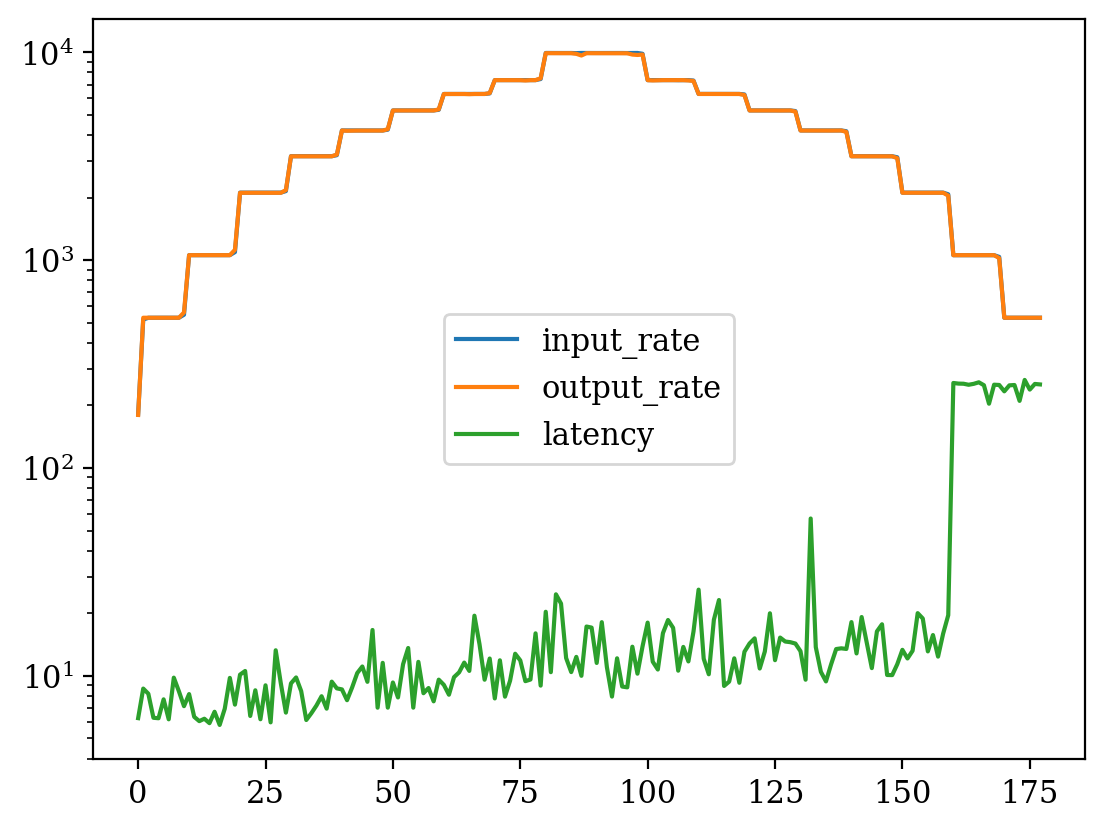

In [16]:
df.iloc[:, :3].plot(logy=True)

In [17]:
abs_path = os.path.join("..\\dag-1\\datasets", "load_stimulus_"+ exp_ls +".csv")
df.to_csv(abs_path, sep=',')